In [1]:
# Google ドライブをマウントするには、このセルを実行してください。
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#マウントできたか確認
!ls /content/drive/

'My Drive'


In [0]:
# My Drive直下にzipファイルを置いて、Colabのtemporaryディレクトリにコピーする
#.がcurrent directory
!cp /content/drive/My\ Drive/image.zip .

In [4]:
# 解凍
!unzip image.zip

Archive:  image.zip
   creating: image/
  inflating: image/.DS_Store         
   creating: __MACOSX/
   creating: __MACOSX/image/
  inflating: __MACOSX/image/._.DS_Store  
   creating: image/minor_class/
  inflating: image/minor_class/.DS_Store  
   creating: __MACOSX/image/minor_class/
  inflating: __MACOSX/image/minor_class/._.DS_Store  
   creating: image/minor_class/test/
   creating: image/minor_class/test/cocacola/
  inflating: image/minor_class/test/cocacola/cocacola_capture_69.jpg  
   creating: __MACOSX/image/minor_class/test/
   creating: __MACOSX/image/minor_class/test/cocacola/
  inflating: __MACOSX/image/minor_class/test/cocacola/._cocacola_capture_69.jpg  
  inflating: image/minor_class/test/cocacola/.DS_Store  
  inflating: __MACOSX/image/minor_class/test/cocacola/._.DS_Store  
  inflating: image/minor_class/test/cocacola/00000003633999_A01.jpg  
  inflating: image/minor_class/test/cocacola/170px-15-09-26-RalfR-WLC-0098.jpg  
  inflating: image/minor_class/test/cocacola/

In [0]:
#コピー作成のためにフォルダ切る
#five class学習用
!mkdir -p /content/pics/five_class
#unknownを含めて学習するためにsix classも
!mkdir -p /content/pics/six_class

In [0]:
#imageをコピー(five_classとsix_classをそれぞれ)

!cp -r /content/image/major_class /content/pics/five_class
!cp -r /content/image/minor_class /content/pics/five_class

!cp -r /content/image/major_class /content/pics/six_class
!cp -r /content/image/minor_class /content/pics/six_class

#five classのフォルダからはtrainのunknown削除
!rm -r /content/pics/five_class/major_class/train/unknown
!rm -r /content/pics/five_class/minor_class/train/unknown


In [7]:
#リアルタイムでLossをプロットするためのライブラリをインポート
!pip install livelossplot

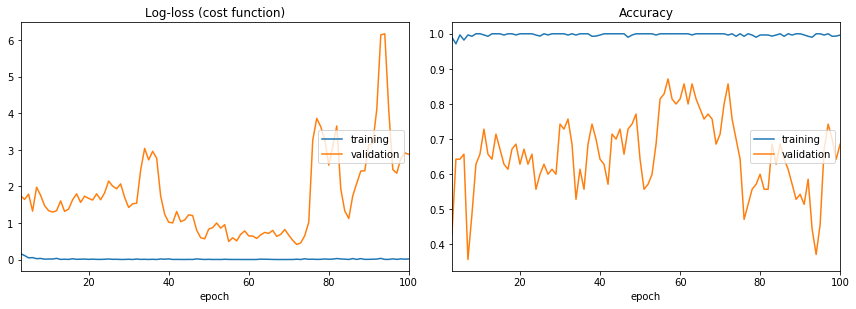

Log-loss (cost function):
training   (min:    0.000, max:    1.321, cur:    0.016)
validation (min:    0.413, max:    6.172, cur:    2.876)

Accuracy:
training   (min:    0.518, max:    1.000, cur:    0.996)
validation (min:    0.357, max:    0.871, cur:    0.686)

Epoch 00100: val_loss did not improve from 0.41258


In [0]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D,Input,Dropout
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenetv2 import MobileNetV2
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import CSVLogger,EarlyStopping
from livelossplot.keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint

%matplotlib inline

n_categories=6
batch_size=32

img_dir ='/content/pics/six_class/minor_class/train'
file_name='MobileNetV2_shape224_six_class_minor_epoch_100'

base_model=MobileNetV2(input_shape=(224,224,3),
                       weights='imagenet',
                       include_top=False)

#add new layers instead of FC networks
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dropout(0.5)(x)
x=Dense(1024, activation='relu')(x)
prediction=Dense(n_categories,activation='softmax')(x)
model=Model(inputs=base_model.input,outputs=prediction)

#fix weights before MobileNet
for layer in base_model.layers[:85]:
      layer.trainable=False

model.compile(optimizer=Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#model.summary()


#model_checkpoint
model_checkpoint = ModelCheckpoint(
    filepath=file_name+'.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    period=1
)

#save model
data_gen_params = {
      "rotation_range": 15,
      "width_shift_range": 0.2,
      "height_shift_range": 0.2,
      "rescale": 1.0/255,
      "shear_range": 0.2,
      "zoom_range": 0.2,
      "vertical_flip": True,
      #"horizontal_flip": True, #現実的にhorizontal flipは考えにくいのでなし
      "validation_split":0.2 #val_dataの比率を設定すればtrainのフォルダのみからvalデータを作れる
}

data_gene=ImageDataGenerator(**data_gen_params)


train_generator = data_gene.flow_from_directory(
      img_dir,
      target_size=(224,224),
      batch_size=batch_size,
      class_mode='categorical',
      shuffle=True,
      subset='training'#subsetをtrainingに設定
)

val_generator = data_gene.flow_from_directory(
      img_dir, # trainと同じdirectory
      target_size=(224,224),
      batch_size=batch_size,
      class_mode='categorical',
      shuffle=True,
      subset='validation' #subsetをvalidationに設定
)


hist=model_six.fit_generator(
     train_generator,
     steps_per_epoch=15,
     epochs=100,
     verbose=1,
     validation_data=val_generator,
     validation_steps=10,
     #callbacks=[EarlyStopping(patience=2),PlotLossesCallback()]
     callbacks=[PlotLossesCallback(), model_checkpoint]
)


In [0]:
#学習結果をgoogle driveに保管
!cp MobileNetV2_shape224_irohas_epoch_150.h5 drive/My\ Drive/ 

In [0]:
#学習結果の検証
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

test_dir = "/content/pics/six_class/minor_class/test"
n_test_samples=8

test_datagen=ImageDataGenerator(rescale=1.0/255)
test_generator=test_datagen.flow_from_directory(
      test_dir,
      target_size=(224,224),
      shuffle=False
)
model_six.load_weights('MobileNetV2_shape224_six_class_minor_epoch_100.h5')
proba = model_six.predict_generator(test_generator, steps=n_test_samples)
print(np.max(proba, axis=1))
preds = np.argmax(proba, axis=1)
print(preds)
print(preds.shape)

for idx, _ in enumerate(test_generator):
    img = np.array(Image.open(test_dir + "/" + test_generator.filenames[idx]))
    plt.imshow(img)
    plt.title(str(preds[idx]) + ", " + str(np.max(proba[idx])), color='white')
    plt.show()
    #print("name: ", test_generator.filenames[idx], ", pred: ", preds[idx])


Output hidden; open in https://colab.research.google.com to view.